# Gapfilling NDVI/LST with machine learning


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump
from scipy import stats
import geopandas as gpd
from pprint import pprint
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import lightgbm as lgbm
from lightgbm import LGBMRegressor

import shap
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.classification import predict_xr, HiddenPrints
from dea_tools.spatial import xr_rasterize

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Analysis parameters
* `path`: The path to the input shapefile. A default shapefile is provided.

In [2]:
model_var='NDVI'
n_samples = 6500

### Assemble datasets for training and predicting

In [3]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'

datasets = [
     'NDVI_5km_monthly_1982_2022_wGaps.nc',
     # 'NDVI_5km_monthly_1982_2022.nc',
    'rain_5km_monthly_1981_2022.nc',
    'rain_cml3_5km_monthly_1982_2022.nc',
    'rain_cml6_5km_monthly_1982_2022.nc',
    'rain_cml12_5km_monthly_1982_2022.nc',
    'srad_5km_monthly_1982_2022.nc',
    'tavg_5km_monthly_1982_2022.nc',
    'vpd_5km_monthly_1982_2022.nc',
    'MOY_5km_monthly_1982_2022.nc'
           ]

In [4]:
dss = []
for d in datasets:
    xx = xr.open_dataset(base+d).sel(time=slice('1982','2021')).drop('spatial_ref')
    dss.append(xx)
ds = xr.merge(dss)

ds = assign_crs(ds, crs ='epsg:4326')

## Training & testing data: equal random sampling of bioclimatic regions

In [5]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
gdf.head()

,bioclimatic_regions,region_name,geometry
0,1.0,Tropics,"MULTIPOLYGON (((122.92500 -16.42500, 122.92500..."
1,2.0,Savanna,"MULTIPOLYGON (((147.67500 -19.87500, 147.72500..."
2,3.0,Warm Temperate,"MULTIPOLYGON (((145.42500 -36.02500, 145.42500..."
3,4.0,Cool Temperate,"MULTIPOLYGON (((147.07500 -43.37500, 147.12500..."
4,5.0,Mediterranean,"MULTIPOLYGON (((135.82500 -34.87500, 135.82500..."


In [6]:
# Dictionary to save results 
results = []
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds.NDVI)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = ds.where(mask)

    #sample equivalent num of samples per region
    df = dss.to_dataframe().dropna().sample(n=int(n_samples/len(gdf)), random_state=0).reset_index()
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.append(df)


Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


In [11]:
df = pd.concat(results).reset_index(drop=True)
df = df.drop(['time' 'spatial_ref'], axis=1)

### Independent validation samples

In [12]:
validation = df.sample(n=1000, random_state=0)

In [14]:
df = df.drop(validation.index)
print(len(df), 'training samples')

5498 training samples


### Plot the location of the samples

In [24]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

gdf_val = gpd.GeoDataFrame(
    validation, geometry=gpd.points_from_xy(validation.longitude, validation.latitude), crs="EPSG:4326"
)

# gdf_val.explore(column='NDVI', vmin=0)

In [17]:
y = df['NDVI']
x = df.drop(['NDVI','longitude'], axis=1)

## Testing model using nested CV

In [18]:
# Create the parameter grid using distributions
param_grid = {
    'num_leaves': stats.randint(5,50),
    'min_child_samples':stats.randint(10,30),
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': stats.randint(5,25),
    'n_estimators': [200, 300, 400, 500],
}

In [20]:
outer_cv = KFold(n_splits=5, shuffle=True,
                   random_state=0)

# lists to store results of CV testing
acc = []
rmse=[]
r2=[]

i = 1
for train_index, test_index in outer_cv.split(x, y):
    print(f"Working on {i}/5 outer CV split", end='\r')
    model = LGBMRegressor(random_state=1,
                          verbose=-1,
                          # n_jobs=-1
                          )

    # index training, testing
    X_tr, X_tt = x.iloc[train_index, :], x.iloc[test_index, :]
    y_tr, y_tt = y.iloc[train_index], y.iloc[test_index]
    
    #simple random split on inner fold
    inner_cv = KFold(n_splits=3,
                     shuffle=True,
                     random_state=0)
    
    clf = RandomizedSearchCV(
                   model,
                   param_grid,
                   verbose=0,
                   n_iter=100,
                   # n_jobs=-1,
                   cv=inner_cv.split(X_tr, y_tr)
                  )
    
    #prevents extensive print statements
    clf.fit(X_tr, y_tr, callbacks=None)
    
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # MAE
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # RMSE
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    
    #1:1 plots for each fold (save to csv so we can make a plot later on)
    df = pd.DataFrame({'Test':y_tt, 'Pred':pred}).reset_index(drop=True)

    df.to_csv("/g/data/os22/chad_tmp/climate-carbon-interactions/results/cross_validation/"+str(i)+"_lgbm.csv")
    
    i += 1

### Create a single 1:1 plot out of the folds 

None of the test samples overlap between folds, and every sample has been tested


In [21]:
dffs=[]
for i in range(1,5+1):
    df = pd.read_csv(f'/g/data/os22/chad_tmp/climate-carbon-interactions/results/cross_validation/{i}_lgbm.csv', usecols=['Test', 'Pred'])
    dffs.append(df)

cross_df = pd.concat(dffs)

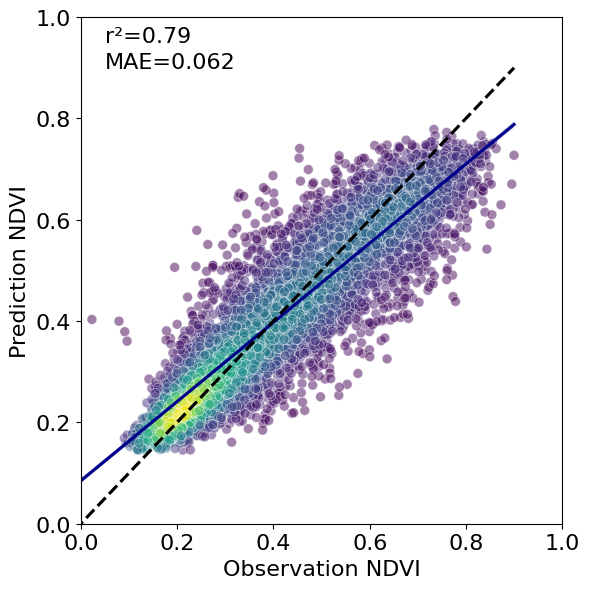

In [22]:
fig,ax = plt.subplots(1,1, figsize=(6,6))

xy = np.vstack([cross_df['Test'],cross_df['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=cross_df, x='Test',y='Pred',c=z, s=50, lw=1, alpha=0.5, ax=ax)
sb.regplot(data=cross_df, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=cross_df, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

plt.xlabel('Observation NDVI', fontsize=16)
plt.ylabel('Prediction NDVI', fontsize=16)
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=16)
ax.text(.05, .9, 'MAE={:.2g}'.format(np.mean(acc)),
            transform=ax.transAxes, fontsize=16)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
# fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/cross_val_"+model_var+"_lgbm_"+suffix+".png")

## Optimize model using all training data

Using a randomized strategy so we can search through more variables, with 500 iterations


In [25]:
outer_cv = KFold(n_splits=5, shuffle=True,
                   random_state=0)

clf = RandomizedSearchCV(LGBMRegressor(verbose=-1),
                   param_grid,
                   verbose=1,
                   n_iter=500,
                   # n_jobs=-1,
                   cv=outer_cv
                  )

clf.fit(x, y, callbacks=None)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=LGBMRegressor(verbose=-1), n_iter=500,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14a5ca3164f0>,
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14a5cb4803a0>,
                                        'n_estimators': [200, 300, 400, 500],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14a5ca2db1c0>},
                   verbose=1)

In [26]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The best score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'boosting_type': 'dart',
 'max_depth': 19,
 'min_child_samples': 17,
 'n_estimators': 400,
 'num_leaves': 21}


The best score using these parameters is: 
0.8


## Fit on all data using best params

In [27]:
model = LGBMRegressor(**clf.best_params_)

model.fit(x,y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2053
[LightGBM] [Info] Number of data points in the train set: 5498, number of used features: 9
[LightGBM] [Info] Start training from score 0.414597


LGBMRegressor(boosting_type='dart', max_depth=19, min_child_samples=17,
              n_estimators=400, num_leaves=21)

## Compare with independent validation data

In [28]:
y_val = validation['NDVI']
x_val = validation.drop(['NDVI','longitude'], axis=1)

In [29]:
pred = model.predict(x_val)

r2 = r2_score(y_val, pred)
ac = mean_absolute_error(y_val, pred)
df_val = pd.DataFrame({'Test':y_val, 'Pred':pred}).reset_index(drop=True)

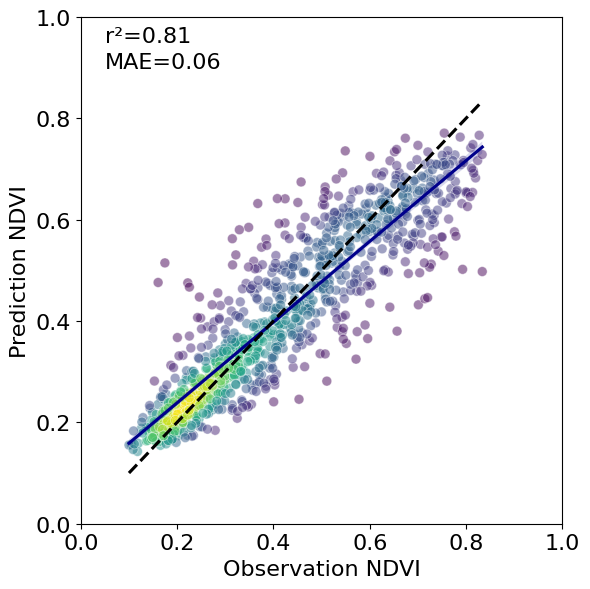

In [30]:
fig,ax = plt.subplots(1,1, figsize=(6,6))

xy = np.vstack([df_val['Test'],df_val['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=df_val, x='Test',y='Pred',c=z, s=50, lw=1, alpha=0.5, ax=ax)
sb.regplot(data=df_val, x='Test',y='Pred', scatter=False, color='darkblue', ax=ax)
sb.regplot(data=df_val, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

plt.xlabel('Observation NDVI', fontsize=16)
plt.ylabel('Prediction NDVI', fontsize=16)
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=16)
ax.text(.05, .9, 'MAE={:.2g}'.format(ac),
            transform=ax.transAxes, fontsize=16)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
# fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/cross_val_"+model_var+"_lgbm_"+suffix+".png")

### Save the model

In [31]:
dump(model, '/g/data/os22/chad_tmp/climate-carbon-interactions/results/models/gapfill/gapfill_'+model_var+'_LGBM.joblib')

['/g/data/os22/chad_tmp/climate-carbon-interactions/results/models/gapfill/gapfill_NDVI_LGBM.joblib']

## Examine feature importance using SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

In [32]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

In [33]:
vals= np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(x.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['col_name'] = feature_importance['col_name'].str.removesuffix("_RS")

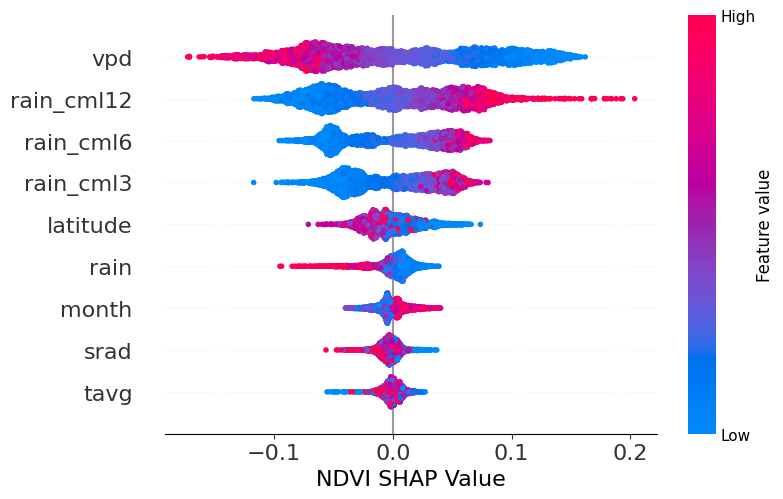

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,7))
shap.summary_plot(shap_values, max_display=9, show=False, feature_names=feature_importance['col_name'])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(15) 
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel(model_var+' SHAP Value', fontsize=16)
plt.tight_layout()
# fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/feature_importance_"+model_var+"_lgbm_"+suffix+".png")